# For halo 0 of each sim, graph and save the model

Loaded simulation in 0.0 seconds.


<Figure size 1500x500 with 0 Axes>

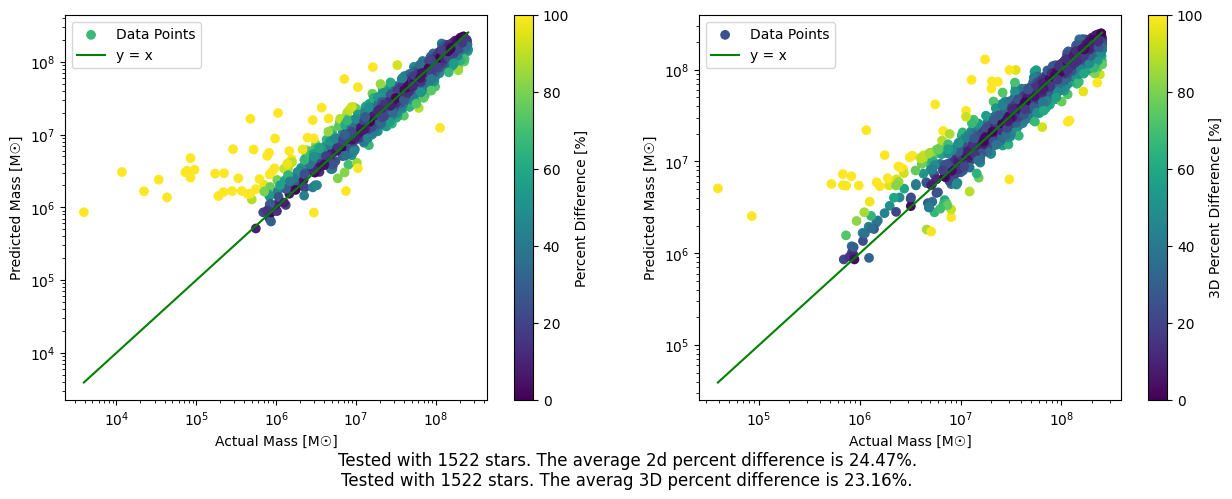

<Figure size 1500x500 with 0 Axes>

In [1]:
import numpy as np, joblib, time
from graph import graph, graph2, graph3, graph4
from sklearn.model_selection import train_test_split 
from stellarutil import Simulation
from sklearn.neighbors import KNeighborsRegressor 
from IPython.display import clear_output

def split_data(X, Y, test_size=0.2, random_state=42):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    X_TRAIN = np.array(X_train) 
    Y_TRAIN = np.array(Y_train)
    X_TEST = np.array(X_test)
    Y_TEST = np.array(Y_test)
    return X_TRAIN, X_TEST, Y_TRAIN, Y_TEST

def processSim(sim: Simulation, name: str, percent:int):
    X = []
    Y = []
    X2 = []
    Y2 = []
    start = time.time()
    clear_output()
    print(f'Loaded simulation in {round(time.time()-start,2)} seconds.')
    # Get the x,y,z positions of each dm particle in the simulation, normalize it with halo center
    dark_x = sim.particles['dark']['position'][:,0]
    dark_y = sim.particles['dark']['position'][:,1]
    dark_z = sim.particles['dark']['position'][:,2]
    # Get the mass of each dm particle in the simulation
    DM_MASS = 1303.0022
    # Get the halo and restrict
    halo = sim.get_halo(0)
    halo.restrict_percentage(percent)
    # Get the x,y,z positions of each dm particle in the simulation, normalize it with halo center
    halo_dark_x = dark_x - halo.xc
    halo_dark_y = dark_y - halo.yc
    halo_dark_z = dark_z - halo.zc
    # Get the distance of each dm particle from the center of the indicated dark matter halo
    halo_dark_distances = np.sqrt(np.square(halo_dark_x) + np.square(halo_dark_y) + np.square(halo_dark_z))
    halo_dark_distances = np.sort(halo_dark_distances)
    # Get X and Y for 2D models
    for star in halo.stars:
        X.append([star.x, star.y, star.x, star.y, star.x, star.y, star.vz, star.a, star.get_2DR(), star.get_2DR(), star.get_2DR()])
        count = np.searchsorted(halo_dark_distances, star.get_2DR())
        Y.append(count * DM_MASS)
    # Get X2 and Y2 for 3D models
    for star in halo.stars:
        X2.append([star.x, star.y, star.x, star.y, star.x, star.y, star.vz, star.a, star.get_3DR(), star.get_3DR(), star.get_3DR(), star.z, star.z, star.z])
        count = np.searchsorted(halo_dark_distances, star.get_3DR())
        Y2.append(count * DM_MASS)
    # Split the data
    X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = split_data(X, Y)
    X_TRAIN2, X_TEST2, Y_TRAIN2, Y_TEST2 = split_data(X2, Y2)
    # Create the KNN Regressor, train, and then predict
    knn_regressor = KNeighborsRegressor(n_neighbors=5, weights='distance')
    knn_regressor.fit(X_TRAIN, Y_TRAIN)
    Y_PRED = np.array(knn_regressor.predict(X_TEST))
    # 3D model
    knn_regressor2 = KNeighborsRegressor(n_neighbors=5, weights='distance')
    knn_regressor2.fit(X_TRAIN2, Y_TRAIN2)
    Y_PRED2 = np.array(knn_regressor2.predict(X_TEST2))
    
    c = np.zeros(len(Y_TEST))
    non_zero_indices = np.logical_and(Y_TEST != 0, Y_PRED != 0)
    c[non_zero_indices] = (np.abs(Y_TEST[non_zero_indices] - Y_PRED[non_zero_indices]) / ((Y_TEST[non_zero_indices] + Y_PRED[non_zero_indices]) / 2)) * 100

    c2 = np.zeros(len(Y_TEST2))
    non_zero_indices = np.logical_and(Y_TEST2 != 0, Y_PRED2 != 0)
    c2[non_zero_indices] = (np.abs(Y_TEST2[non_zero_indices] - Y_PRED2[non_zero_indices]) / ((Y_TEST2[non_zero_indices] + Y_PRED2[non_zero_indices]) / 2)) * 100

    graph4(name + " " + str(percent), Y_TEST, Y_PRED, c, Y_TEST2, Y_PRED2, c2)

names = ['m10q_res250md', 'm10r_res250md', 'm10v_res250md', 'm10v_res030md']
names = ['m09_res030md', 'm10v_res030md']

for name in names:
    sim = Simulation(simulation_name=name, species=['star', 'dark'])
    processSim(sim, name, 100)
    processSim(sim, name, 15)
    processSim(sim, name, 5)
    processSim(sim, name, 1)
